In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/bardo.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 3)

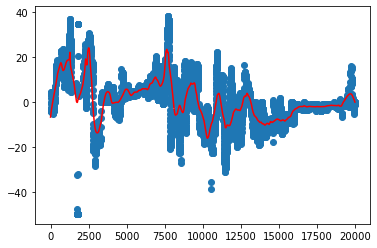

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
# grade_data = np.arctan(grade_data/100)
# yhat = np.arctan(grade_smooth/100)
# plt.scatter(distance_data, grade_data)
# plt.plot(distance_data, yhat, 'r')

In [7]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

grade_data = np.arctan(grade_data/100)

7670
306


In [8]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

# x_data = x_data[x_data <= distance]
# slope_data = slope_data[x_data <= distance]

In [9]:
# create GEKKO model
m = GEKKO()

In [10]:
t_est = 1 * 60 * 60
t_min = 0.7 * 60 * 60
t_max = 4 * 60 * 60

In [11]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [12]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
beta = (4 * 4184 * 1/75 * N_m * X)/(E0 * np.sqrt(S * tau))
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)
mu = (k*N_m*X)/(np.sqrt(S*tau))

In [13]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [14]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0
n0 = 0.00201818/N_m

e_crit = 0.15 * e0

In [15]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sigma0 * E_data/(e0 * e_crit) + 0.75 * sigma0 * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sigma0

# slope data to create spline
# x_data = np.linspace(0, 1, 3000)
# slope_data = np.array(600*[1/18 * np.pi] + 600 * [-1/18 * np.pi] + 600*[1/36 * np.pi] + 600 * [-1/36 * np.pi] + 600 * [1/9 * np.pi])

In [16]:
# time points [s]
nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

In [17]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
N = m.Var(value=n0, lb=0.0) # oxidation rate

sigma = m.Var(value=sigma0, lb=0) #breathing rate
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [18]:
# FV - final time
# tf = m.FV(value=t_est/t_scale,lb=t_min/t_scale,ub=t_max/t_scale)
tf = m.FV(value=t_est/t_scale, lb = 0.1)
tf.STATUS = 1

In [19]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [20]:
# energy decrease at the end
m.cspline(E, sigma, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [21]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v) + beta * N)*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(mu * N * (1 - N))*tf)
m.Equation(alpha * (sigma - u * v) + beta * N <= 0)
m.Equation((distance - X*x)*final<=0)

m.fix_final(E, 0)

In [22]:
m.options.IMODE = 6
m.options.MAX_ITER=30000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 90.156.80.122_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           11
   Intermediates:            0
   Connections  :            6
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           1699
 Number of total equations: -         1600
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :           -101
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

  82r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 2.03e-04   6.7 1.00e+00 1.00e+00f  1
  83r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 6.10e-04   6.2 1.00e+00 1.00e+00f  1
  84r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 1.83e-03   5.7 1.00e+00 1.00e+00f  1
  85r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 5.49e-03   5.3 1.00e+00 1.00e+00f  1
  86r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 1.65e-02   4.8 1.00e+00 1.00e+00f  1
  87r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 4.94e-02   4.3 1.00e+00 2.84e-01f  1
  88r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 1.48e-01   3.8 1.00e+00 9.45e-04f  1
  89r 1.0498839e-02 1.74e+04 1.00e+03  -9.0 4.50e-01   3.4 1.00e+00 3.36e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.0498839e-02 1.74e+04 1.01e+03  -9.0 1.60e+00   2.9 1.00e+00 5.01e-02f  1
  91r 1.0498839e-02 1.74e+04 1.01e+03  -9.0 4.81e+00   2.4 1.00e+00 1.67e-04f  1
  92r 1.0498839e-02 1.74e+04 1.01e+03  -8.6 1.44e+01   1.9 1.00e+00 3.75e-05f  1
  93r 1.0498839e-02 1.74e+04

 174r 1.0851718e-02 1.72e+04 4.00e+03  -6.8 2.30e-03   6.1 1.00e+00 1.65e-02f  1
 175r 1.0851718e-02 1.72e+04 9.95e+03  -6.3 2.47e-03   6.6 1.00e+00 1.98e-03f  1
 176r 1.0851718e-02 1.72e+04 2.53e+05  -4.4 2.54e-03   7.0 1.00e+00 8.99e-01f  1
 177r 1.0851718e-02 1.72e+04 4.77e+03  -2.4 1.44e-03   6.5 8.98e-01 1.00e+00f  1
 178r 1.0851718e-02 1.72e+04 5.63e+03  -3.9 1.54e-03   6.0 1.00e+00 1.01e-01f  1
 179r 1.0851718e-02 1.72e+04 4.09e+04  -5.4 1.56e-03   6.5 1.00e+00 7.79e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 1.0851718e-02 1.72e+04 4.04e+04  -6.8 1.32e-03   6.0 1.00e+00 1.38e-02f  1
 181r 1.0851718e-02 1.72e+04 2.89e+04  -6.9 6.46e-04   6.4 1.00e+00 2.90e-01f  1
 182r 1.0851718e-02 1.72e+04 2.60e+04  -7.1 1.37e-03   5.9 1.00e+00 1.01e-01f  1
 183r 1.0851718e-02 1.72e+04 2.34e+04  -7.2 4.01e-03   5.5 1.00e+00 9.87e-02f  1
 184r 1.0851718e-02 1.72e+04 2.28e+04  -9.0 1.49e-03   5.9 1.00e+00 2.57e-02f  1
 185r 1.0851718e-02 1.72e+04

 312r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 6.36e-04   6.2 1.00e+00 6.35e-01f  1
 313r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 1.91e-03   5.8 1.00e+00 2.12e-03f  1
 314r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 5.72e-03   5.3 1.00e+00 8.79e-06f  1
 315r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 1.89e-02   4.8 1.00e+00 2.10e-02f  1
 316r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 6.80e-03   5.2 1.00e+00 5.66e-04f  1
 317r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 2.02e-02   4.7 1.00e+00 2.04e-02f  1
 318r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 7.57e-03   5.2 1.00e+00 6.41e-02f  1
 319r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 2.18e-02   4.7 1.00e+00 5.15e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 8.55e-03   5.1 1.00e+00 2.94e-02f  1
 321r 1.0851809e-02 1.72e+04 1.07e+03  -9.0 2.88e-02   4.6 1.00e+00 1.65e-02f  1
 322r 1.0851811e-02 1.72e+04 1.26e+03  -0.8 8.51e-02   4.2 1.00e+00 9.83e-03f  1
 323r 1.0851820e-02 1.72e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r 1.0948059e-02 1.71e+04 1.01e+03  -7.5 5.56e-04   6.3 1.00e+00 6.48e-02f  1
 451r 1.0948059e-02 1.71e+04 1.02e+03  -9.0 1.80e-03   5.8 1.00e+00 4.07e-02f  1
 452r 1.0948059e-02 1.71e+04 1.02e+03  -9.0 5.22e-03   5.4 1.00e+00 1.99e-02f  1
 453r 1.0948059e-02 1.71e+04 1.02e+03  -9.0 1.50e-02   4.9 1.00e+00 9.19e-03f  1
 454r 1.0948059e-02 1.71e+04 1.02e+03  -9.0 4.43e-02   4.4 1.00e+00 8.49e-03f  1
 455r 1.0948059e-02 1.71e+04 1.03e+03  -9.0 1.65e-02   4.8 1.00e+00 2.67e-02f  1
 456r 1.0948059e-02 1.71e+04 1.03e+03  -9.0 4.84e-02   4.4 1.00e+00 1.77e-02f  1
 457r 1.0948059e-02 1.71e+04 1.03e+03  -9.0 1.81e-02   4.8 1.00e+00 3.22e-02f  1
 458r 1.0948059e-02 1.71e+04 1.03e+03  -9.0 5.45e-02   4.3 1.00e+00 2.92e-02f  1
 459r 1.0948059e-02 1.71e+04 1.03e+03  -4.3 2.07e-02   4.7 1.00e+00 1.96e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r 1.0948059e-02 1.71e+04

 553  1.0959448e-02 1.55e+04 1.48e+04  -5.6 1.62e+05    -  1.21e-03 2.77e-05h  6
 554  1.1301696e-02 1.55e+04 4.19e+05   2.0 1.68e+04    -  2.41e-02 2.40e-04h  1
 555  1.3828627e-02 1.55e+04 4.48e+05   2.6 1.55e+05    -  9.29e-04 4.21e-04f  1
 556  1.3922000e-02 1.55e+04 9.84e+05   0.6 6.43e+03    -  6.27e-03 1.49e-03h  1
 557  1.3942950e-02 1.55e+04 4.83e+06   0.6 2.85e+04    -  2.79e-03 3.15e-04h  2
 558  1.3963372e-02 1.55e+04 6.96e+06   0.6 2.68e+04    -  5.89e-03 2.89e-04h  5
 559  1.3972245e-02 1.55e+04 3.13e+07   0.6 4.27e+04    -  3.20e-03 1.06e-04h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  1.4057421e-02 1.54e+04 1.34e+07   0.6 1.82e+04    -  8.92e-03 1.24e-03f  3
 561  1.4145842e-02 1.54e+04 2.21e+07   0.6 7.60e+03    -  2.62e-03 1.31e-03f  4
 562  1.4147781e-02 1.54e+04 2.21e+07   0.6 1.16e+04    -  1.00e-02 2.79e-05h  1
 563  1.4239365e-02 1.54e+04 1.36e+07   0.6 1.18e+04    -  1.34e-03 1.22e-03f  3
 564r 1.4239365e-02 1.54e+04

 669r 2.9735196e-02 1.15e+04 2.43e+05   1.4 6.80e-03   6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r 2.9735262e-02 1.15e+04 8.45e+04   1.4 7.71e-03   6.2 1.00e+00 1.00e+00f  1
 671r 2.9735286e-02 1.15e+04 3.85e+05   1.4 3.50e-03   6.6 1.00e+00 1.00e+00f  1
 672r 2.9735296e-02 1.15e+04 5.71e+05   1.4 2.20e-03   7.1 1.00e+00 1.00e+00f  1
 673r 2.9735296e-02 1.15e+04 1.36e+05   0.1 8.20e-04   7.5 1.00e+00 1.00e+00f  1
 674r 2.9735295e-02 1.15e+04 1.88e+03  -1.7 1.03e-04   7.0 1.00e+00 1.00e+00f  1
 675r 2.9735295e-02 1.15e+04 1.00e+03  -3.7 2.90e-04   6.5 1.00e+00 1.00e+00f  1
 676r 2.9735295e-02 1.15e+04 1.00e+03  -5.4 8.71e-04   6.1 1.00e+00 1.00e+00f  1
 677r 2.9735295e-02 1.15e+04 1.00e+03  -6.6 2.61e-03   5.6 1.00e+00 7.20e-01f  1
 678r 2.9735295e-02 1.15e+04 1.00e+03  -7.3 8.07e-03   5.1 1.00e+00 3.12e-03f  1
 679r 2.9735295e-02 1.15e+04 1.02e+03  -9.0 2.66e-02   4.6 1.00e+00 1.36e-01f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  1.7836163e-01 1.09e+01 4.26e+04  -0.5 1.52e+02    -  1.72e-01 9.87e-01H  1
 771  1.7857667e-01 9.89e+00 8.97e+05  -1.1 4.25e+00    -  9.89e-01 9.63e-02h  1
 772  2.2409101e-01 7.35e-01 7.58e+04  -1.7 4.25e+00    -  9.78e-01 9.28e-01h  1
 773  2.1471932e-01 9.71e-03 4.65e+03  -3.3 4.11e+00    -  1.00e+00 9.91e-01h  1
 774  4.5449809e-03 5.73e-05 4.87e-02  -4.9 2.10e+01    -  1.00e+00 1.00e+00f  1
 775  6.0453681e-04 2.78e-04 7.34e+02  -6.3 2.12e+00    -  1.00e+00 9.07e-01h  1
 776  2.7070248e-04 1.71e-01 1.44e+01  -6.3 6.92e+00    -  1.00e+00 9.80e-01h  1
 777  4.2544258e-04 3.05e-02 4.70e-01  -6.1 2.02e+00    -  1.00e+00 1.00e+00h  1
 778  2.3193363e-04 1.11e-02 1.81e+00  -6.5 1.25e+00    -  1.00e+00 1.00e+00h  1
 779  2.0947331e-04 9.98e-02 2.62e-01  -6.6 6.08e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  1.7763809e-04 1.77e-02

 861  2.1690334e-04 1.28e-02 5.16e+03  -6.5 2.44e-01   5.2 1.52e-02 1.52e-02h  1
 862  2.1690334e-04 2.54e-03 2.90e+05  -6.5 1.76e-01   4.7 2.15e-04 1.00e+00h  1
 863  2.1690334e-04 2.46e-03 2.78e+05  -6.5 1.25e-01   4.2 1.00e+00 3.47e-02h  1
 864  2.1690334e-04 1.30e-03 1.34e+05  -6.5 1.30e-01   3.7 1.00e+00 4.93e-01h  1
 865  2.1690334e-04 1.30e-03 1.34e+05  -8.0 2.74e-02   5.1 1.00e+00 4.55e-05h  1
 866  2.1690334e-04 1.29e-03 2.98e+05  -7.7 4.21e-02   4.6 1.00e+00 2.34e-03h  1
In iteration 866, 1 Slack too small, adjusting variable bound
 867  2.1690333e-04 2.02e-04 1.43e+05  -7.7 3.20e-02   5.0 1.00e+00 8.83e-01h  1
 868  2.1690332e-04 2.87e-05 5.43e+02  -8.1 1.58e-02   4.5 1.00e+00 1.00e+00h  1
 869  2.1690328e-04 6.32e-06 1.04e+02  -9.5 9.03e-03   4.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870  2.1690318e-04 8.66e-06 2.77e+02  -7.6 1.49e-02   3.6 1.00e+00 1.00e+00h  1
 871  2.1690285e-04 4.39e-06 9.62e+03  -8.0 3.9

 953  1.1150572e-04 4.85e-05 2.05e-05  -9.3 1.74e-02  -4.7 1.00e+00 1.00e+00h  1
 954  1.1141739e-04 1.48e-05 8.61e-06  -9.9 3.28e-03  -4.3 1.00e+00 1.00e+00h  1
 955  1.1137671e-04 2.88e-04 1.59e-03 -11.0 1.81e-01  -4.8 3.34e-02 8.56e-02h  1
 956  1.1132979e-04 2.01e-04 2.69e-04  -9.1 5.84e-02  -5.3 1.00e+00 1.00e+00h  1
 957  1.1276520e-04 1.00e-03 1.05e-01  -8.0 4.34e-01  -5.7 6.10e-01 6.68e-01h  1
 958  1.1227311e-04 8.22e-04 6.71e-02  -8.3 2.74e-01  -6.2 4.04e-01 3.87e-01h  1
 959  1.1127166e-04 2.62e-03 3.97e-02  -8.3 9.24e-01  -6.7 2.76e-01 3.31e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960  1.0999325e-04 7.60e-03 2.88e-02  -8.3 2.45e+00  -7.2 1.13e-01 1.73e-01f  1
 961  1.1467133e-04 6.02e-03 5.29e-02  -7.4 1.01e+00  -6.7 4.93e-01 4.99e-01f  1
 962  1.1337358e-04 6.62e-04 1.43e-03  -7.7 4.69e-02  -5.4 1.00e+00 1.00e+00h  1
 963  1.1333681e-04 1.34e-05 1.94e-05  -7.7 1.85e-02  -5.0 1.00e+00 1.00e+00h  1
 964  1.1316665e-04 8.25e-05

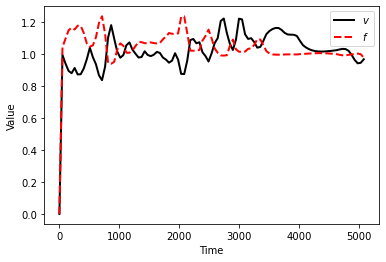

In [23]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

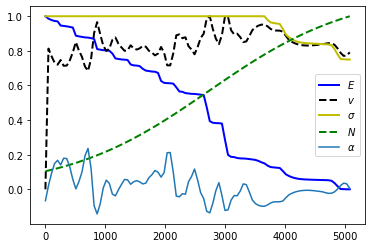

In [24]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm, np.array(sigma.value)/max(sigma.value), 'y-', lw=2, label=r'$\sigma$')
plt.plot(tm, np.array(N.value)/max(N.value), 'g--', lw=2, label=r'$N$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [26]:
5077/3600

1.4102777777777777